## **Notebook to automatically generate compound figures for report**
Author: patrick.mccarthy@dtc.ox.ac.uk

In [1]:
from pathlib import Path
import pickle
import glob
import os
import copy
import traceback

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colormaps as cm
from scipy.special import softmax
from scipy.linalg import svd
from sklearn import svm
from sklearn.decomposition import KernelPCA, PCA
from scipy.stats import entropy

from thalamocortex.models import CTCNet
from thalamocortex.utils import create_data_loaders, activation_hook, get_neuron_weights, plot_receptive_field

/Users/patmccarthy/miniconda3/envs/thalamocortex/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
save_path = "/Users/patmccarthy/Documents/phd/rotation1/results_11_03_25/mnist"

In [3]:
results_paths = {
    "no feedback": "/Users/patmccarthy/Documents/thalamocortex/results/06_03_25_feedforward_mnist/0_CTCNet_TC_none",
    "driver": "/Users/patmccarthy/Documents/thalamocortex/results/11_03_25_driver_mnist/0_CTCNet_TC_add_reciprocal_readout",
    "modulator": "/Users/patmccarthy/Documents/thalamocortex/results/11_03_25_mod1_mnist/0_CTCNet_TC_multi_pre_activation_reciprocal",
    # "mod2": "/Users/patmccarthy/Documents/thalamocortex/results/11_03_25_mod2_mnist/...",
}

In [4]:
model_plot_list = ["no feedback", "driver", "modulator"]

Load loss and accuracy data

In [ ]:
# load models, learning stats, results 
results = {}
for model_name, path in results_paths.items():
    
    # NOTE: note loading trained models because can instantiate from final weights

    # hyperparameters
    with open(Path(f"{path}", "hyperparams.pkl"), "rb") as handle:
        hp = pickle.load(handle)

    # learning progress
    with open(Path(f"{path}", "learning.pkl"), "rb") as handle:
        learning = pickle.load(handle)

    # store results and params in dict 
    results[model_name] = {"val_losses": learning["val_losses"],
                           "train_losses": learning["train_losses"],
                           "val_topk_accs": learning["val_topk_accs"],
                           "train_topk_accs": learning["train_topk_accs"],
                           "train_time": learning["train_time"],
                           "state_dicts": learning["state_dicts"],
                           "hyperparams": hp}
    
    # get number of epochs to train for
    n_epochs = len(learning["train_topk_accs"])

    if model_name in ["driver", "modulator"]:
        results[model_name]["val_losses"].pop(0)
        results[model_name]["val_topk_accs"].pop(0)
        results[model_name]["state_dicts"].pop(0)

    else:
        epoch_range = np.arange(0, n_epochs)

    # get top-1 accuracies in more convenient form for plotting
    train_top1_accs = []
    val_top1_accs = []

    # store training info
    for epoch in np.arange(n_epochs):
        train_top1_accs.append(learning["train_topk_accs"][epoch][1])
        val_top1_accs.append(learning["val_topk_accs"][epoch][1])
    results[model_name]["train_top1_accs"] = np.array(train_top1_accs)
    results[model_name]["val_top1_accs"] = np.array(val_top1_accs)
    

Load decoding data

In [ ]:
# load decoding accuracies if don't want to re-run
with open(Path(save_path, "svm_decoding_acc.pkl"), "rb") as handle:
    accuracies = pickle.load(handle)

Load activations decomp data

In [ ]:
# load decoding accuracies if don't want to re-run
with open(Path(save_path, "activations_reduced.pkl"), "rb") as handle:
    accuracies = pickle.load(handle)

Load test set for colour-coding

In [ ]:
# create loaders
trainset_loader, testset_loader, metadata = create_data_loaders(dataset=results[models_selected[0]]["hyperparams"]["dataset"],
                                                                norm=results[models_selected[0]]["hyperparams"]["norm"],
                                                                batch_size=32,
                                                                save_path="/Users/patmccarthy/Documents/ThalamoCortex/data")


In [ ]:
# load full test set
X_all = []
y_all = []
for X, y in iter(testset_loader):
    # X_all.append(X.detach().numpy()[:, 0, :, :])
    # y_all.append(y.detach().numpy()[:])
    X_all.append(X[:, :, :])
    y_all.append(y[:])
if results[model_plot_list[0]]["hyperparams"]["dataset"] in ["BinaryMNIST", "LeftRightMNIST"]:
    # Concatenate along the first axis (num_samples)
    X_all_arr = np.concatenate(X_all, axis=0)  # Shape: (num_samples, 1, 28, 28)
    y_all_reshaped = np.concatenate(y_all, axis=0)  # Shape: (num_samples,)

    # Reshape X to [samples, features]
    X_all_reshaped = X_all_arr.reshape(X_all_arr.shape[0], -1)  # Shape: (num_samples, 28*28)
else:
    X_all_tensor = torch.cat(X_all, dim=0)  # Shape: [num_samples, 1, 28, 28]
    y_all_tensor = torch.cat(y_all, dim=0)  # Shape: [num_samples]

    # Convert to NumPy
    X_all_arr = X_all_tensor.numpy()  # Shape: (num_samples, 1, 28, 28)
    y_all_reshaped = y_all_tensor.numpy()  # Shape: (num_samples,)

    # Reshape X to [samples, features]
    X_all_reshaped = X_all_arr.reshape(X_all_arr.shape[0], -1)  # Shape: (num_samples, 28*28)

Make loss and accuracy plots

In [ ]:
# loss through time
n_epochs = len(results[model_plot_list[0]]["val_losses"])
colours = ["r", "m", "b", "o"]
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
models_plotted = []
models_plotted_idx = 0
for _, (model_name, model_results) in enumerate(results.items()):
    if model_name in model_plot_list:
        models_plotted.append(model_name)
        models_plotted_idx += 1

        n_epochs = len(model_results["val_losses"])

        ax.plot(np.arange(n_epochs), np.median(np.array(model_results["val_losses"]), axis=-1), ls="--", linewidth=1, label=f"{model_name} val.", c=colours[models_plotted_idx-1])
        ax.plot(np.arange(n_epochs), np.median(np.array(model_results["train_losses"]), axis=-1), ls="-", linewidth=1, label=f"{model_name} train", c=colours[models_plotted_idx-1])

# ax.set_xticks(range(1, len(models_plotted)+1), models_plotted)
ax.set_ylabel("cross entropy")
ax.set_xlabel("epoch")
ax.set_xlim(0, n_epochs)
ax.set_ylim(0, 2.5)
ax.legend(loc="upper right")
fig.savefig(Path(save_path, "loss_curve.png"))

In [ ]:
# accuracy through time
n_epochs = len(results[model_plot_list[0]]["val_losses"])
fig, ax = plt.subplots(1, 1, figsize=(10, 3), layout="constrained")
ax.axhline(10, ls="--", c="k", label="chance")
models_plotted = []
models_plotted_idx = 0
for _, (model_name, model_results) in enumerate(results.items()):
    if model_name in model_plot_list:
        models_plotted.append(model_name)
        models_plotted_idx += 1

        n_epochs = len(model_results["val_losses"])

        # ax.plot(np.arange(n_epochs), np.array(model_results["val_top1_accs"]),ls="--", label=f"{model_name} val.", linewidth=1, c=colours[models_plotted_idx-1])
        ax.plot(np.arange(n_epochs), np.array(model_results["train_top1_accs"]) * 100, ls="-", label=f"{model_name} train", linewidth=1, c=colours[models_plotted_idx-1])

# ax.set_xticks(range(1, len(models_plotted)+1), models_plotted)
ax.set_ylabel("top-1 accuracy (%)")
ax.set_xlabel("epoch")
ax.set_ylim(0, 100)
ax.set_xlim(0, n_epochs)
ax.legend(loc="center right")

Make decoding plots

In [ ]:
for layer in accuracies.keys():
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    for model_idx, model_selected in enumerate(accuracies[layer].keys()):
        ax.plot(accuracies[layer][model_selected].keys(), np.array(list(accuracies[layer][model_selected].values())) * 100, c=colours[model_idx], label=model_selected)
    ax.axhline(10, ls="--", c="k", label="chance")
    ax.set_title(f"SVM decoding MNIST from {layer} activations")
    ax.set_ylabel("classification accuracy (%)")
    ax.set_xlabel("epoch")
    ax.set_ylim(0, 100)
    ax.set_xlim(list(accuracies[layer][model_selected].keys())[0], list(accuracies[layer][model_selected].keys())[-1])
    ax.legend(loc="center right")

Make activations plots

In [ ]:
# activations analysis
kernel = "cosine"
epochs = {"before training": 0,
          "after training": 799}

# generate colourmap
jet_cmap = plt.colormaps["jet"]  
N = 10
colors = jet_cmap(np.linspace(0, 1, N)) 
discrete_cmap = mcolors.ListedColormap(colors)

for layer in accuracies.keys():
    
    if layer == "thal":
        model_list = ["driver", "modulator"]
    else:
        model_list = ["driver", "modulator", "no feedback"]

    fig, ax = plt.subplots(len(model_list), len(epochs), figsize=(4 * len(epochs), 4 * len(model_list)), layout="constrained")

    for model_idx, model_selected in enumerate(model_list):

        for epoch_idx, (epoch_name, epoch) in enumerate(epochs.items()):
            
            scatter = ax[model_idx, epoch_idx].scatter(reduced_activations[model_selected][epoch_name][:, 0], reduced_activations[model_selected][epoch_name][:, 1], c=y_all_reshaped, cmap=discrete_cmap, alpha=0.7, s=0.2)
            plt.colorbar(scatter, label="class ID")
            
            ax[model_idx, epoch_idx].set_title(f"{model_selected}, {epoch_name}")
            ax[model_idx, epoch_idx].set_xlabel("PC1")
            ax[model_idx, epoch_idx].set_ylabel("PC2")

    fig.suptitle(f"{reduced_activations['method']} on {layer} activations with {reduced_activations['kernel']} kernel")

Place plots in grid

In [ ]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(3, 3)

# Assign different sizes to subplots
ax1 = fig.add_subplot(gs[0, :])  # Top row spans all columns
ax2 = fig.add_subplot(gs[1, :-1])  # Middle-left (spanning two columns)
ax3 = fig.add_subplot(gs[1:, -1])  # Right column spanning two rows
ax4 = fig.add_subplot(gs[2, 0])  # Bottom-left
ax5 = fig.add_subplot(gs[2, 1])  # Bottom-middle

# Example plots
ax1.plot(x, np.sin(x), 'b')
ax2.plot(x, np.cos(x), 'r')
ax3.hist(np.random.randn(100), bins=20, color='g')
ax4.scatter(np.random.rand(10), np.random.rand(10))
ax5.bar(range(5), np.random.rand(5))

plt.tight_layout()
plt.show()

Make ablation plots

In [ ]:
accuracies_reformat = {kind: [v[799] for _, v in accuracies[kind].items()] for kind in accuracies.keys()}
accuracies_reformat["thal_to_ctx1 ablated"][0] = None
accuracies_reformat["thal_to_ctx2 ablated"][0] = None
accuracies_reformat["all feedback ablated"][0] = None

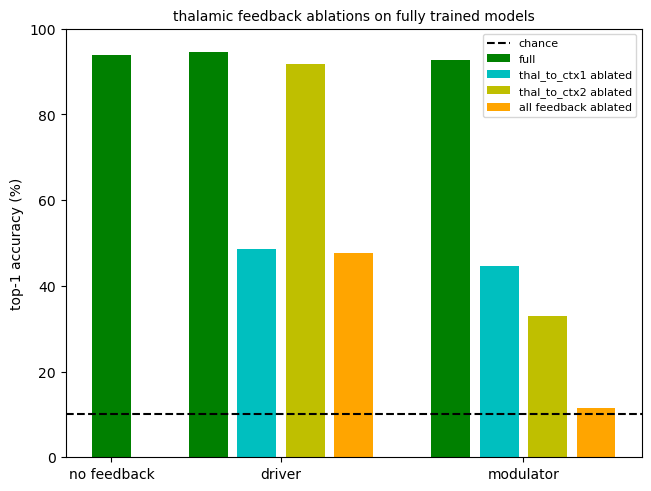

In [ ]:
# bar plot of accuracy for ablated models
colours = ["g", "c", "y", "orange"]
fig, ax = plt.subplots(1, 1)
ax.axhline(10, ls="--", c="k", label="chance")
x = 0
offset = 0
tick_locs = []
x_group = 0
for model_idx, model in enumerate(model_plot_list):
    x_group +=  offset
    num_bars = 0
    for ablation_idx, (ablation_type, accuracies_) in enumerate(accuracies_reformat.items()):
        x = x_group + ablation_idx
        if accuracies_[model_idx] is not None:
            num_bars += 1
            if model == "driver":
                label = ablation_type
            else:
                label=None
            ax.bar(x, accuracies_[model_idx] * 100, facecolor=colours[ablation_idx], label=label)
            offset = 5
        else:
            offset = 2
    tick_locs.append(x_group+num_bars/2 -.5)
ax.legend()
ax.set_ylim(0, 100)
ax.set_xticks(tick_locs, model_plot_list)
ax.set_ylabel("top-1 accuracy (%)")
ax.set_title(f"thalamic feedback ablations on fully trained models")
fig.savefig(Path(save_path, f"accuracy_ablation.png"))